# Define Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from matplotlib.image import imread
from tensorflow.keras import regularizers, initializers, Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, SpatialDropout2D, GlobalMaxPooling2D, AveragePooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from typing import Any, Dict, List, Tuple

# Define Variables

In [2]:
kernel_s = (3, 3)  # Size of weights of a convolutional layer
pool_s = (2, 2)  # Size of window to compute max pooling 2D of
input_shape=(5, 5, 3)

In [3]:
image = np.array([
    [[139, 142, 65], [32, 124, 201], [12, 234, 84], [23, 68, 216], [174, 12, 184]],
    [[74, 231, 129], [64, 244, 184], [217, 147, 53], [ 201, 23, 195], [84, 127, 38]],
    [[206, 23, 134], [126, 201, 215], [173, 45, 218], [207, 194, 219], [128, 194, 53]],
    [[12, 215, 185], [196, 231, 53], [73, 167, 43], [120, 32, 94], [185, 194, 63]],
    [[126, 218, 242], [63, 128, 84], [95, 128, 216], [107, 210, 79], [194, 96, 196]]
], dtype=np.int32)

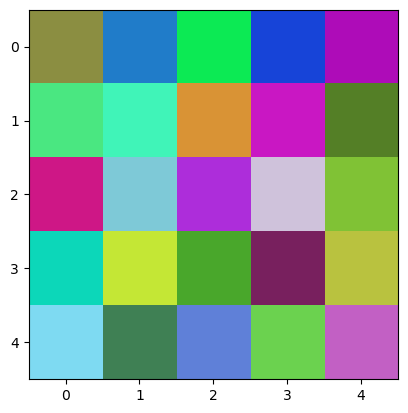

In [4]:
plt.imshow(image, interpolation='nearest')
plt.show()

In [5]:
def sigmoid(x: np.float32):  # Remove later
    return 1 / (1 + np.exp(-x))

# Conv2D Layer

In [6]:
# Compute first layer Conv2D on my own
weights = np.ones((*kernel_s, 3))  # 3x3x3 matrix initialized with ones
# weights = np.array(conv.weights).reshape((*kernel_s, 3))  # Would work as well with initialization of the tensorflow Conv2D weights
resulting_image = np.zeros((3, 3, 1))  # 3x3x1 matrix for results initialized with zeros

for row in range(3):  # Iterate over rows
    for col in range(3):  # Iterate over columns
        element_wise_multiplication = image[row:row + 3, col:col + 3] * weights  # Elementwise multiplication
        raveled_elements = element_wise_multiplication.ravel()  # Ravel elements for computing sum of them
        resulting_image[row][col][0] = sum(raveled_elements)

resulting_image

array([[[3717.],
        [3920.],
        [3523.]],

       [[3859.],
        [3935.],
        [3487.]],

       [[3816.],
        [3717.],
        [3723.]]])

In [7]:
# Compute first layer with predefined layer Conv2D
converted_image = np.array(image, dtype=np.float32)  # Convert for using in Conv2D layer
images_to_compute = np.array([converted_image])
conv = Conv2D(1, kernel_s, input_shape=input_shape, kernel_initializer="ones", use_bias=False)  # Initialize the weights with ones like above
conv(images_to_compute)[0]  # Tensorflow expects multiple images for AI training etc.

<tf.Tensor: shape=(3, 3, 1), dtype=float32, numpy=
array([[[3717.],
        [3920.],
        [3523.]],

       [[3859.],
        [3935.],
        [3487.]],

       [[3816.],
        [3717.],
        [3723.]]], dtype=float32)>

In [8]:
class OwnConv2D:

    def __init__(self, units: int = 1, kernel_s: Tuple[int, int] = (3, 3), activation: str=None):
        self._units = units
        self._kernel_s = kernel_s
        self._activation = activation

    def __call__(self, images: np.ndarray, ) -> np.ndarray:
        # Convert images into correct format
        converted_images = np.array(images, dtype=np.float32)

        # Define weights and resulting array
        n_images = converted_images.shape[0]
        n_rows = converted_images.shape[1] - (self._kernel_s[0] - 1)
        n_cols = converted_images.shape[2] - (self._kernel_s[1] - 1)
        weights = np.ones((*self._kernel_s, converted_images[0, 0, 0].shape[0]))
        resulting_images = np.zeros((n_images, n_rows, n_cols, self._units))  # nxmx1 matrix for results initialized with zeros

        # Compute output of convolution
        for unit in range(self._units):  # Compute output of convolution for each unit (remove later)
            for img in range(n_images):  # Iterate over all images
                for row in range(n_rows):  # Iterate over rows
                    for col in range(n_cols):  # Iterate over columns
                        element_wise_multiplication = converted_images[img, row:row + self._kernel_s[0], col:col + self._kernel_s[1]] * weights  # Elementwise multiplication
                        raveled_elements = element_wise_multiplication.ravel()  # Ravel elements for computing sum of them
                        res_img_row_col = sum(raveled_elements)

                        # Use activation function, if requested
                        if self._activation is not None:
                            if self._activation.lower() == "relu":
                                res_img_row_col = max(0, res_img_row_col)
                            elif self._activation.lower() == "sigmoid":
                                res_img_row_col = sigmoid(res_img_row_col)

                        resulting_images[img][row][col][unit] = res_img_row_col  # Replace "unit" with "0" later

        return resulting_images

# Concatenate Conv2D layers (own & predefined)

In [9]:
# Invert image for testing activation function ReLu (remove later)
# image = -image

In [10]:
# Own model
new_img = OwnConv2D(kernel_s=kernel_s, activation="relu")(np.array([image]))
print(new_img)
OwnConv2D(kernel_s=kernel_s, activation="rElU")(new_img)

[[[[3717.]
   [3920.]
   [3523.]]

  [[3859.]
   [3935.]
   [3487.]]

  [[3816.]
   [3717.]
   [3723.]]]]


array([[[[33697.]]]])

In [11]:
# Predefined Conv2D model from tensorflow
converted_image = np.array(image, dtype=np.float32)  # Convert for using in Conv2D layer
images_to_compute = np.array([converted_image])
conv = Conv2D(1, kernel_s, input_shape=input_shape, kernel_initializer="ones", use_bias=False, activation="relu")  # Remove later ReLu
conv2 = Conv2D(1, kernel_s, input_shape=(3, 3, 1), kernel_initializer="ones", use_bias=False, activation="relu")  # Remove later ReLu
print(conv(images_to_compute))
conv2(conv(images_to_compute))  # Results in a rounding error

tf.Tensor(
[[[[3717.]
   [3920.]
   [3523.]]

  [[3859.]
   [3935.]
   [3487.]]

  [[3816.]
   [3717.]
   [3723.]]]], shape=(1, 3, 3, 1), dtype=float32)


<tf.Tensor: shape=(1, 1, 1, 1), dtype=float32, numpy=array([[[[33704.]]]], dtype=float32)>

# Test models on real image

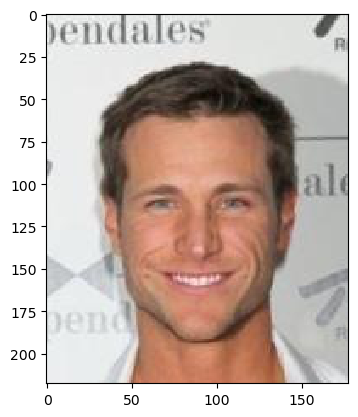

(218, 178, 3)

In [12]:
real_image = imread("019226.jpg")  # Read with matplotlib
real_images = np.array([real_image], dtype=np.float32)  # Like before multiple images are expected
plt.imshow(real_image, interpolation='nearest')
plt.show()
real_image.shape

In [13]:
# Own model
new_img_own_model = OwnConv2D(kernel_s=kernel_s)(real_images)
print(new_img_own_model, "\n")
new_img_own_model_2 = OwnConv2D(kernel_s=kernel_s)(new_img_own_model)
print(new_img_own_model_2)

[[[[6342.]
   [6348.]
   [6357.]
   ...
   [5808.]
   [6036.]
   [5862.]]

  [[6390.]
   [6384.]
   [6375.]
   ...
   [5964.]
   [6087.]
   [5958.]]

  [[6345.]
   [6360.]
   [6399.]
   ...
   [6048.]
   [6093.]
   [5988.]]

  ...

  [[6408.]
   [6408.]
   [6408.]
   ...
   [5943.]
   [5760.]
   [5610.]]

  [[6420.]
   [6414.]
   [6411.]
   ...
   [6096.]
   [5973.]
   [5856.]]

  [[6432.]
   [6420.]
   [6414.]
   ...
   [6171.]
   [6126.]
   [6066.]]]] 

[[[[57300.]
   [57387.]
   [57357.]
   ...
   [48369.]
   [52659.]
   [53844.]]

  [[56817.]
   [57165.]
   [57315.]
   ...
   [51180.]
   [53790.]
   [54267.]]

  [[55056.]
   [55797.]
   [56529.]
   ...
   [53055.]
   [54303.]
   [54369.]]

  ...

  [[57672.]
   [57672.]
   [57672.]
   ...
   [52551.]
   [51213.]
   [49878.]]

  [[57693.]
   [57684.]
   [57684.]
   ...
   [54000.]
   [53028.]
   [51879.]]

  [[57735.]
   [57708.]
   [57708.]
   ...
   [54885.]
   [54348.]
   [53601.]]]]


In [14]:
# Predfined Conv2D model from tensorflow
converted_images = np.array(real_images, dtype=np.float32)  # Convert for using in Conv2D layer
conv = Conv2D(1, kernel_s, input_shape=(218, 178, 3), kernel_initializer="ones", use_bias=False)
conv2 = Conv2D(1, kernel_s, input_shape=(216, 176, 3), kernel_initializer="ones", use_bias=False)
new_img_predef_model = conv(converted_images)
new_img_predef_model_2 = conv2(new_img_predef_model)
print(new_img_predef_model, "\n")
print(new_img_predef_model_2)

tf.Tensor(
[[[[6342.]
   [6348.]
   [6357.]
   ...
   [5808.]
   [6036.]
   [5862.]]

  [[6390.]
   [6384.]
   [6375.]
   ...
   [5964.]
   [6087.]
   [5958.]]

  [[6345.]
   [6360.]
   [6399.]
   ...
   [6048.]
   [6093.]
   [5988.]]

  ...

  [[6408.]
   [6408.]
   [6408.]
   ...
   [5943.]
   [5760.]
   [5610.]]

  [[6420.]
   [6414.]
   [6411.]
   ...
   [6096.]
   [5973.]
   [5856.]]

  [[6432.]
   [6420.]
   [6414.]
   ...
   [6171.]
   [6126.]
   [6066.]]]], shape=(1, 216, 176, 1), dtype=float32) 

tf.Tensor(
[[[[57300.]
   [57387.]
   [57357.]
   ...
   [48369.]
   [52659.]
   [53844.]]

  [[56817.]
   [57165.]
   [57315.]
   ...
   [51180.]
   [53790.]
   [54267.]]

  [[55056.]
   [55797.]
   [56529.]
   ...
   [53055.]
   [54303.]
   [54369.]]

  ...

  [[57672.]
   [57672.]
   [57672.]
   ...
   [52551.]
   [51213.]
   [49878.]]

  [[57693.]
   [57684.]
   [57684.]
   ...
   [54000.]
   [53028.]
   [51879.]]

  [[57735.]
   [57708.]
   [57708.]
   ...
   [54885.]
   [54348.]

In [15]:
# Check for equality
print(np.allclose(new_img_own_model, new_img_predef_model))
print(np.allclose(new_img_own_model_2, new_img_predef_model_2))

assert np.allclose(new_img_own_model, new_img_predef_model)
assert np.allclose(new_img_own_model_2, new_img_predef_model_2)

True
True


# MaxPooling2D Layer

In [16]:
# Original image
image = np.array([
    [[139, 142, 65], [32, 124, 201], [12, 234, 84], [23, 68, 216], [174, 12, 184]],
    [[74, 231, 129], [64, 244, 184], [217, 147, 53], [ 201, 23, 195], [84, 127, 38]],
    [[206, 23, 134], [126, 201, 215], [173, 45, 218], [207, 194, 219], [128, 194, 53]],
    [[12, 215, 185], [196, 231, 53], [73, 167, 43], [120, 32, 94], [185, 194, 63]],
    [[126, 218, 242], [63, 128, 84], [95, 128, 216], [107, 210, 79], [194, 96, 196]]
], dtype=np.int32)

In [17]:
# Compute first layer MaxPooling2D on my own
resulting_image = np.zeros((2, 2, 3))  # 2x2x3 matrix for results initialized with zeros

for row in range(0, 4, 2):  # Iterate over rows (ignore last row)
    for col in range(0, 4, 2):  # Iterate over columns (ignore last column)
        for rgb in range(3):  # Iterate over all RGB values
            interesting_elements = image[row:row + 2, col:col + 2, rgb]  # Find relevent RGB values
            interesting_elements = interesting_elements.ravel()  # Ravel intersting elements for easier computation of maximum
            highest_rgb = max(interesting_elements)
            resulting_image[row // 2][col // 2][rgb] = highest_rgb

resulting_image

array([[[139., 244., 201.],
        [217., 234., 216.]],

       [[206., 231., 215.],
        [207., 194., 219.]]])

In [18]:
# Compute first layer with predefined layer MaxPooling2D
converted_image = np.array(image, dtype=np.float32)  # Convert for using in MaxPooling2D layer
images_to_compute = np.array([converted_image])
max_pool = MaxPooling2D(pool_size=pool_s)  # Initialize the weights with ones like above
max_pool(images_to_compute)[0]  # Tensorflow expects multiple images for AI training etc.

<tf.Tensor: shape=(2, 2, 3), dtype=float32, numpy=
array([[[139., 244., 201.],
        [217., 234., 216.]],

       [[206., 231., 215.],
        [207., 194., 219.]]], dtype=float32)>

In [19]:
class OwnMaxPooling2D:

    def __init__(self, pool_s: Tuple[int, int], strides: int = pool_s):
        self._pool_s = pool_s  # Size of window to compute max pooling 2D of
        self._strides = strides  # Number of steps in each direction (x & y)f or moving the window

    def __call__(self, images: np.ndarray) -> np.ndarray:
        # Convert images into correct format
        converted_images = np.array(images, dtype=np.float32)

        # Define weights and resulting array
        n_images = converted_images.shape[0]
        n_rows = converted_images.shape[1] // self._strides[0]  # Dimension of resulting image (x-axis)
        n_cols = converted_images.shape[2] // self._strides[1]  # Dimension of resulting image (y-axis)
        n_rgbs = converted_images.shape[3]  # Number of RGB values, remains in result
        resulting_images = np.zeros((n_images, n_rows, n_cols, n_rgbs))  # nxmx1 matrix for results initialized with zeros

        # Compute output of max pooling
        for img in range(n_images):  # Iterate over all images
            for row in range(0, converted_images.shape[1] - 1, self._strides[0]):  # Iterate over rows (ignore last row)
                for col in range(0, converted_images.shape[2] - 1, self._strides[1]):  # Iterate over columns (ignore last column)
                    for rgb in range(n_rgbs):  # Iterate over all RGB values
                        interesting_elements = converted_images[img, row:row + self._strides[0], col:col + self._strides[1], rgb]  # Find relevent RGB values
                        interesting_elements = interesting_elements.ravel()  # Ravel intersting elements for easier computation of maximum
                        highest_rgb = max(interesting_elements)
                        resulting_images[img][row // self._strides[0]][col // self._strides[1]][rgb] = highest_rgb

        return resulting_images

In [20]:
own_max_pool = OwnMaxPooling2D(pool_s=pool_s)  # Use default strides = pool_s
print(own_max_pool(images=np.array([image])))  # Same result as above
print(own_max_pool(own_max_pool(images=np.array([image]))))  # Concatenation still possible

[[[[139. 244. 201.]
   [217. 234. 216.]]

  [[206. 231. 215.]
   [207. 194. 219.]]]]
[[[[217. 244. 219.]]]]


In [21]:
# Compute first layer with predefined layer MaxPooling2D
print(max_pool(images_to_compute))  # Same result as above
print(max_pool(max_pool(images_to_compute)))  # Concatenation still possible

tf.Tensor(
[[[[139. 244. 201.]
   [217. 234. 216.]]

  [[206. 231. 215.]
   [207. 194. 219.]]]], shape=(1, 2, 2, 3), dtype=float32)
tf.Tensor([[[[217. 244. 219.]]]], shape=(1, 1, 1, 3), dtype=float32)


# First part of the model

In [22]:
# Predefined model
pre_defined_model = Sequential([
    Conv2D(1, kernel_s, input_shape=(218, 178, 3), kernel_initializer="ones", use_bias=False, activation='relu'),
    MaxPooling2D(pool_s),

    Conv2D(1, kernel_s, kernel_initializer="ones", use_bias=False, activation='relu'),
    MaxPooling2D(pool_s),

    Conv2D(1, kernel_s, kernel_initializer="ones", use_bias=False, activation='relu'),
    MaxPooling2D(pool_s),

    Conv2D(1, kernel_s, kernel_initializer="ones", use_bias=False, activation='relu'),
    MaxPooling2D(pool_s),

    Conv2D(1, kernel_s, kernel_initializer="ones", use_bias=False, activation='relu'),
    MaxPooling2D(pool_s),
])

pre_defined_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 216, 176, 1)       27        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 108, 88, 1)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 106, 86, 1)        9         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 53, 43, 1)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 51, 41, 1)         9         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 20, 1)        0

In [23]:
converted_image = np.array(real_image, dtype=np.float32)  # Convert for using in MaxPooling2D layer
images_to_compute = np.array([converted_image])
preds_predefined_model = pre_defined_model.predict_step(images_to_compute)
preds_predefined_model

<tf.Tensor: shape=(1, 4, 3, 1), dtype=float32, numpy=
array([[[[39135032.],
         [31686098.],
         [32060224.]],

        [[33711808.],
         [30734988.],
         [29036562.]],

        [[34668032.],
         [30075784.],
         [28744688.]],

        [[36904536.],
         [29787772.],
         [28180816.]]]], dtype=float32)>

In [24]:
class OwnSequential:

    def __init__(self, layers: List[Any]):
        self._layers = layers

    def predict(self, images: np.ndarray) -> np.ndarray:
        res = np.copy(images)

        for layer in self._layers:
            res = layer(res)

        return res

In [25]:
own_model = OwnSequential([
    OwnConv2D(kernel_s=kernel_s),
    OwnMaxPooling2D(pool_s),

    OwnConv2D(kernel_s=kernel_s, activation='relu'),
    OwnMaxPooling2D(pool_s),

    OwnConv2D(kernel_s=kernel_s, activation='relu'),
    OwnMaxPooling2D(pool_s),

    OwnConv2D(kernel_s=kernel_s, activation='relu'),
    OwnMaxPooling2D(pool_s),

    OwnConv2D(kernel_s=kernel_s, activation='relu'),
    OwnMaxPooling2D(pool_s),
])

preds_own_model = own_model.predict(images_to_compute)
preds_own_model

array([[[[39135032.],
         [31686100.],
         [32060220.]],

        [[33711808.],
         [30734986.],
         [29036564.]],

        [[34668036.],
         [30075784.],
         [28744690.]],

        [[36904532.],
         [29787772.],
         [28180812.]]]])

In [26]:
print(np.allclose(preds_predefined_model, preds_own_model))
assert np.allclose(preds_predefined_model, preds_own_model)

True


# Multiple units

In [27]:
converted_image = np.array(image, dtype=np.float32)  # Convert for using in Conv2D layer
images_to_compute = np.array([converted_image])

conv = Conv2D(2, kernel_s, input_shape=input_shape, kernel_initializer="ones", use_bias=False, activation="relu")  # Remove later ReLu
conv2 = Conv2D(2, kernel_s, use_bias=False, kernel_initializer="ones", activation="relu")  # Remove later ReLu
conv3 = Conv2D(1, kernel_s, use_bias=False, kernel_initializer="ones", activation="relu")  # Remove later ReLu
conv4 = Conv2D(4, kernel_s, use_bias=False, kernel_initializer="ones", activation="relu")  # Remove later ReLu

In [28]:
conv(images_to_compute)

<tf.Tensor: shape=(1, 3, 3, 2), dtype=float32, numpy=
array([[[[3717., 3717.],
         [3920., 3920.],
         [3523., 3523.]],

        [[3859., 3859.],
         [3935., 3935.],
         [3487., 3487.]],

        [[3816., 3816.],
         [3717., 3717.],
         [3723., 3723.]]]], dtype=float32)>

In [29]:
print(conv2(conv(images_to_compute)))

tf.Tensor([[[[67408. 67408.]]]], shape=(1, 1, 1, 2), dtype=float32)


In [30]:
print(conv3(conv(images_to_compute)))

tf.Tensor([[[[67408.]]]], shape=(1, 1, 1, 1), dtype=float32)


In [31]:
print(conv4(conv(images_to_compute)))

tf.Tensor([[[[67408. 67408. 67408. 67408.]]]], shape=(1, 1, 1, 4), dtype=float32)


In [32]:
OwnConv2D(units=2, kernel_s=kernel_s, activation="relu")(conv(images_to_compute))

array([[[[67394., 67394.]]]])

In [33]:
OwnConv2D(units=1, kernel_s=kernel_s, activation="relu")(conv(images_to_compute))

array([[[[67394.]]]])

In [34]:
OwnConv2D(units=4, kernel_s=kernel_s, activation="relu")(conv(images_to_compute))

array([[[[67394., 67394., 67394., 67394.]]]])

# Complete first part of the model

In [35]:
# Complete predefined model
pre_defined_model_complete = Sequential([
    Conv2D(32, kernel_s, input_shape=(218, 178, 3), kernel_initializer="ones", use_bias=False, activation='relu'),
    MaxPooling2D(pool_s),

    Conv2D(64, kernel_s, kernel_initializer="ones", use_bias=False, activation='relu'),
    MaxPooling2D(pool_s),

    Conv2D(64, kernel_s, kernel_initializer="ones", use_bias=False, activation='relu'),
    MaxPooling2D(pool_s),

    Conv2D(128, kernel_s, kernel_initializer="ones", use_bias=False, activation='relu'),
    MaxPooling2D(pool_s),

    Conv2D(128, kernel_s, kernel_initializer="ones", use_bias=False, activation='relu'),
    MaxPooling2D(pool_s),
])

pre_defined_model_complete.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 216, 176, 32)      864       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 108, 88, 32)      0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 106, 86, 64)       18432     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 53, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 51, 41, 64)        36864     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 25, 20, 64)      

In [36]:
converted_image = np.array(real_image, dtype=np.float32)  # Convert for using in MaxPooling2D layer
images_to_compute = np.array([converted_image])
preds_predefined_model_complete = pre_defined_model_complete.predict_step(images_to_compute)
preds_predefined_model_complete

<tf.Tensor: shape=(1, 4, 3, 128), dtype=float32, numpy=
array([[[[6.5657749e+14, 6.5657749e+14, 6.5657749e+14, ...,
          6.5657749e+14, 6.5657749e+14, 6.5657749e+14],
         [5.3160545e+14, 5.3160545e+14, 5.3160545e+14, ...,
          5.3160545e+14, 5.3160545e+14, 5.3160545e+14],
         [5.3788023e+14, 5.3788023e+14, 5.3788023e+14, ...,
          5.3788023e+14, 5.3788023e+14, 5.3788023e+14]],

        [[5.6559082e+14, 5.6559082e+14, 5.6559082e+14, ...,
          5.6559082e+14, 5.6559082e+14, 5.6559082e+14],
         [5.1564797e+14, 5.1564797e+14, 5.1564797e+14, ...,
          5.1564797e+14, 5.1564797e+14, 5.1564797e+14],
         [4.8715428e+14, 4.8715428e+14, 4.8715428e+14, ...,
          4.8715428e+14, 4.8715428e+14, 4.8715428e+14]],

        [[5.8163534e+14, 5.8163534e+14, 5.8163534e+14, ...,
          5.8163534e+14, 5.8163534e+14, 5.8163534e+14],
         [5.0458631e+14, 5.0458631e+14, 5.0458631e+14, ...,
          5.0458631e+14, 5.0458631e+14, 5.0458631e+14],
         [4.

In [37]:
own_model_complete = OwnSequential([
    OwnConv2D(units=32, kernel_s=kernel_s, activation='relu'),
    OwnMaxPooling2D(pool_s),

    OwnConv2D(units=64, kernel_s=kernel_s, activation='relu'),
    OwnMaxPooling2D(pool_s),

    OwnConv2D(units=64, kernel_s=kernel_s, activation='relu'),
    OwnMaxPooling2D(pool_s),

    OwnConv2D(units=128, kernel_s=kernel_s, activation='relu'),
    OwnMaxPooling2D(pool_s),

    OwnConv2D(units=128, kernel_s=kernel_s, activation='relu'),
    OwnMaxPooling2D(pool_s),
])

preds_own_model_complete = own_model_complete.predict(images_to_compute)
preds_own_model_complete

array([[[[6.56576885e+14, 6.56576885e+14, 6.56576885e+14, ...,
          6.56576885e+14, 6.56576885e+14, 6.56576885e+14],
         [5.31604544e+14, 5.31604544e+14, 5.31604544e+14, ...,
          5.31604544e+14, 5.31604544e+14, 5.31604544e+14],
         [5.37881236e+14, 5.37881236e+14, 5.37881236e+14, ...,
          5.37881236e+14, 5.37881236e+14, 5.37881236e+14]],

        [[5.65590285e+14, 5.65590285e+14, 5.65590285e+14, ...,
          5.65590285e+14, 5.65590285e+14, 5.65590285e+14],
         [5.15647499e+14, 5.15647499e+14, 5.15647499e+14, ...,
          5.15647499e+14, 5.15647499e+14, 5.15647499e+14],
         [4.87152706e+14, 4.87152706e+14, 4.87152706e+14, ...,
          4.87152706e+14, 4.87152706e+14, 4.87152706e+14]],

        [[5.81633128e+14, 5.81633128e+14, 5.81633128e+14, ...,
          5.81633128e+14, 5.81633128e+14, 5.81633128e+14],
         [5.04587925e+14, 5.04587925e+14, 5.04587925e+14, ...,
          5.04587925e+14, 5.04587925e+14, 5.04587925e+14],
         [4.82255873

In [38]:
print(np.allclose(preds_predefined_model_complete, preds_own_model_complete, rtol=1e-5))  # Rounding errors
print(np.allclose(preds_predefined_model_complete, preds_own_model_complete, rtol=1e-4))  # Rounding errors
print(np.allclose(preds_predefined_model_complete, preds_own_model_complete, rtol=1e-3))  # Rounding errors

assert np.allclose(preds_predefined_model_complete, preds_own_model_complete, rtol=1e-3)

True
True
True


# Whole model

In [39]:
class OwnFlatten:

    def __init__(self):
        pass

    def __call__(self, images: np.ndarray) -> np.ndarray:
        return images.ravel()

class OwnDense:

    def __init__(self, units: int = 1, activation: str = None):
        self._units = units
        self._activation = activation

    def __call__(self, x: np.ndarray) -> np.ndarray:
        # Define weights and resulting array
        weights = np.ones(x.shape[0])  # Weights must have same dimensions as x
        biases = np.zeros(self._units)
        scores = np.zeros(self._units)  # Save results in scores

        # Compute output of convolution
        for unit in range(self._units):  # Compute output of convolution for each unit (remove later)
            score = np.sum(weights * x) + biases[unit]

            # Use activation function, if requested
            if self._activation is not None:
                if self._activation.lower() == "relu":
                    score = max(0, score)
                elif self._activation.lower() == "sigmoid":
                    score = sigmoid(score)

            scores[unit] = score

        return scores

In [40]:
# Test predefined Dense layer
dense_model = Sequential([
    Flatten(),
    Dense(2, activation='relu', kernel_initializer='ones', use_bias=True, bias_initializer='zeros'),
    Dense(2, activation='relu', kernel_initializer='ones', use_bias=True, bias_initializer='zeros'),
])

preds_dense_model_whole = dense_model.predict(images_to_compute)
preds_dense_model_whole

1/1 [==============================] - 0s 66ms/step


array([[38764544., 38764544.]], dtype=float32)

In [41]:
# Test own implemented Dense layer OwnDense
own_dense_model = OwnSequential([
    OwnFlatten(),
    OwnDense(units=2, activation="relu"),
    OwnDense(units=2, activation="relu"),
])

preds_own_dense_model = own_dense_model.predict(images_to_compute)
preds_own_dense_model

array([38756696., 38756696.])

In [42]:
# Test whole model
pre_defined_model_whole = Sequential([
    Conv2D(32, kernel_s, activation='relu', input_shape=(218, 178, 3), kernel_regularizer=regularizers.l2(0.001), padding="VALID"),
    MaxPooling2D(pool_s),

    Conv2D(64, kernel_s, activation='relu'),
    MaxPooling2D(pool_s),

    Conv2D(64, kernel_s, activation='relu'),
    MaxPooling2D(pool_s),

    Conv2D(128, kernel_s, activation='relu'),
    MaxPooling2D(pool_s),

    Conv2D(128, kernel_s, activation='relu'),
    MaxPooling2D(pool_s),

    # Last layer decise -> preparation for this = some layers before
    Flatten(),
    Dense(1024, activation='relu', kernel_initializer='ones', use_bias=True, bias_initializer='zeros'),
#     Dropout(0.5),
    Dense(1, activation='sigmoid', kernel_initializer='ones', use_bias=True, bias_initializer='zeros')
])

pre_defined_model_whole.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 216, 176, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 108, 88, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 106, 86, 64)       18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 53, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 51, 41, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 25, 20, 64)      

In [43]:
preds_whole_model_whole = pre_defined_model_whole.predict(real_images)
preds_whole_model_whole

1/1 [==============================] - 0s 390ms/step


array([[1.]], dtype=float32)

In [44]:
# Test own implemented Dense layer OwnDense
own_model_whole = OwnSequential([
    OwnConv2D(units=32, kernel_s=kernel_s, activation='relu'),
    OwnMaxPooling2D(pool_s),

    OwnConv2D(units=64, kernel_s=kernel_s, activation='relu'),
    OwnMaxPooling2D(pool_s),

    OwnConv2D(units=64, kernel_s=kernel_s, activation='relu'),
    OwnMaxPooling2D(pool_s),

    OwnConv2D(units=128, kernel_s=kernel_s, activation='relu'),
    OwnMaxPooling2D(pool_s),

    OwnConv2D(units=128, kernel_s=kernel_s, activation='relu'),
    OwnMaxPooling2D(pool_s),

    OwnFlatten(),
    OwnDense(units=1024, activation="relu"),
    OwnDense(units=1, activation="sigmoid"),

])

preds_own_model_whole = own_model_whole.predict(real_images)
preds_own_model_whole

array([1.])